In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from tqdm import trange
%matplotlib inline

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [2]:
start_token = "_"
eos = '#'
MAX_LENGTH = 30

In [3]:
data_pairs = pd.read_csv("base_pairs.csv", index_col=0)
data_pairs.loc[:,"word_form"] = data_pairs.word_form.apply(lambda x: start_token + x + eos)
data_pairs.loc[:,"word_norm"] = data_pairs.word_norm.apply(lambda x: start_token + x + eos)
data_pairs.head()

/Users/viktor/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,lex_id,word_norm,word_form,morph_features_form,morph_features_norm
0,1,_ёж#,_ежа#,"NOUN,anim,masc sing,gent","NOUN,anim,masc sing,nomn"
1,1,_ёж#,_ежу#,"NOUN,anim,masc sing,datv","NOUN,anim,masc sing,nomn"
2,1,_ёж#,_ежа#,"NOUN,anim,masc sing,accs","NOUN,anim,masc sing,nomn"
3,1,_ёж#,_ежом#,"NOUN,anim,masc sing,ablt","NOUN,anim,masc sing,nomn"
4,1,_ёж#,_еже#,"NOUN,anim,masc sing,loct","NOUN,anim,masc sing,nomn"


In [4]:
# добавить SOS токен

s = "".join(data_pairs.word_form)
tokens = np.array(list(set(s)))
    
tok2id = dict(zip(tokens, np.arange(tokens.shape[0])))
id2tok = dict(zip(np.arange(tokens.shape[0]), tokens))

print ('There are {} tokens',len(tokens))

print('Vocabular: ' + "".join(tokens))

There are {} tokens 48
Vocabular: 9'2шж’ъиёещбчл5нгср4аыьяу8_птвйюхо6-фм17#кэзц03д


In [5]:
SOS_token = tok2id[start_token]
EOS_token = tok2id[eos]

In [6]:
def to_matrix(words, max_len=None, pad=tok2id[eos], dtype=np.int64):
    """Casts a list of words into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, words))
    words_ix = np.zeros([len(words), max_len], dtype) + pad

    for i in range(len(words)):
        word_ix = list(map(tok2id.get, words[i]))
        words_ix[i, :len(word_ix)] = word_ix

    return words_ix

In [7]:
print('\n'.join(data_pairs.word_form[:10]))
print(to_matrix(data_pairs.word_form[:10]))

_ежа#
_ежу#
_ежа#
_ежом#
_еже#
_ежи#
_ежей#
_ежам#
_ежей#
_ежами#
[[26  9  4 20 40 40 40]
 [26  9  4 24 40 40 40]
 [26  9  4 20 40 40 40]
 [26  9  4 33 37 40 40]
 [26  9  4  9 40 40 40]
 [26  9  4  7 40 40 40]
 [26  9  4  9 30 40 40]
 [26  9  4 20 37 40 40]
 [26  9  4  9 30 40 40]
 [26  9  4 20 37  7 40]]


In [8]:
# Creating training and validation sets using an 80-20 split

input_train, input_test, target_train, target_test = train_test_split(data_pairs.word_norm.values, data_pairs.word_form.values, test_size=0.2)

In [9]:
class pairs_Dataset(Dataset):
    def __init__(self, data, data_form):
        self.data = data
        self.target = data_form
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        return self.data[index], self.target[index]

In [10]:
BATCH_SIZE = 22

train_data = pairs_Dataset(input_train, target_train)

dataset = DataLoader(train_data, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

In [11]:
for batch in dataset:
    print(to_matrix(batch[0]))
    break

[[26 42 13  9 37  9 15 28 20 18 15  9 30  3  7 30 40 40 40]
 [26 42 13  9 41 28 18 33 41 33 29 33 12 15 21 30 40 40 40]
 [26 27 33 43 20 11 18 33 17  7 29  3  7 30 40 40 40 40 40]
 [26 29 47  8 18 16  7 29 20 29  3  7 30 40 40 40 40 40 40]
 [26 41 24 18 33 12  7 29  3  7 30 40 40 40 40 40 40 40 40]
 [26 41 18 20 17 15 33 11 20 30 17 41  7 30 40 40 40 40 40]
 [26 27 33 43 15 20 29 20 28  9 13 22 15  9  9 40 40 40 40]
 [26 17  9 41 44  7 33 15  7 18 33 29 20 15 15 21 30 40 40]
 [26 27 33 47 29  9 47  9 15  7  9 40 40 40 40 40 40 40 40]
 [26 29 20 32 18 24  3  9 29 17 41  7 30 40 40 40 40 40 40]
 [26 18 20 17 27 13  8 29 21 29 20 29  3  7 30 17 23 40 40]
 [26 27 33 47 15 20 28 24  4  7 29 20 31 10  7 30 17 23 40]
 [26 20 15 16 13 33 36 33 11 40 40 40 40 40 40 40 40 40 40]
 [26 43 20 17 28 18  9 13  7 29 20 29  3  7 30 40 40 40 40]
 [26 33 28 27 24 28 20 29  3  7 30 17 23 40 40 40 40 40 40]
 [26 15  9 18 33  4 20 29  3  7 30 40 40 40 40 40 40 40 40]
 [26 27  9 18  9 32  7 28 18  8 15 15 21

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = BATCH_SIZE
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, self.batch_size, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=device)

In [13]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = BATCH_SIZE
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, self.batch_size, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(1),
                                 encoder_outputs)
        output = torch.cat((embedded[0], attn_applied.squeeze()), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=device)

In [14]:
teacher_forcing_ratio = 0.5

def train_batch(X, y, encoder, decoder, encoder_opt, decoder_opt, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_opt.zero_grad()
    decoder_opt.zero_grad()
    max_length = X.shape[1]
    encoder_outputs = torch.zeros(BATCH_SIZE, max_length, encoder.hidden_size, device=device)
    loss = 0
    for i in range(X.shape[1]):
        encoder_output, encoder_hidden = encoder(
            X[:, i], encoder_hidden)
        encoder_outputs[:, i] = encoder_output[0]

    decoder_input = torch.tensor([[int(SOS_token)] * BATCH_SIZE], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if np.random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(y.shape[1]):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, y[:, di])
            decoder_input = y[:, di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(y.shape[1]):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, y[:, di])
#             if decoder_input.item() == EOS_token:
#                 break

    loss.backward()

    encoder_opt.step()
    decoder_opt.step()

    return loss.item()

In [15]:
def plot_history(train_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)    
    plt.xlabel('train steps')
    plt.grid()
    plt.show()
    
    
def train(data, encoder, decoder, n_epochs, print_every=1, plot_every=1, learning_rate=0.01):
    start = time.time()
    plot_losses = []

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    criterion = nn.NLLLoss()

    for epoch in range(n_epochs):
        encoder.train()
        decoder.train()
        loss = 0
        for batch_num, batch in zip(trange(len(data)), data):
            max_len = max(max(map(len, batch[0])), max(map(len, batch[1])))
            X = torch.from_numpy(to_matrix(batch[0], max_len=MAX_LENGTH)).to(device)
            y = torch.from_numpy(to_matrix(batch[1], max_len=MAX_LENGTH)).to(device)
            loss = train_batch(X, y, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
            plot_losses.append(loss / X.shape[0])
            if batch_num == 50:
                break
        clear_output()
        plot_history(plot_losses)

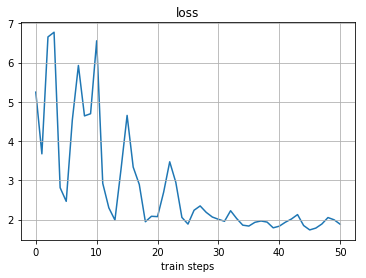

In [17]:
hidden_size = 256
encoder1 = EncoderRNN(tokens.shape[0], hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, tokens.shape[0], dropout_p=0.1).to(device)

train(dataset, encoder1, attn_decoder1, 1)